Import Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

best_model_path = '/content/drive/My Drive/best_model_resnet18.pth'

Mounted at /content/drive


RESNET-18 MODEL STRUCTURE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # out = F.avg_pool2d(out, 4)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


LOAD DATA (CIFAR-10)

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def compute_mean_std(cifar10_dataset):
    """Compute the mean and std value of dataset."""
    dataloader = DataLoader(cifar10_dataset, batch_size=8, shuffle=True, num_workers=2)

    mean = torch.zeros(3)
    std = torch.zeros(3)
    for inputs, _ in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

# Load the training set of CIFAR10
cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
mean, std = compute_mean_std(cifar10_train)
print(f'Mean: {mean}')
print(f'Std Dev: {std}')


100%|██████████| 170498071/170498071 [00:06<00:00, 25082105.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Mean: tensor([0.4914, 0.4822, 0.4465])
Std Dev: tensor([0.2418, 0.2383, 0.2546])


MAKE THE RESNET-18 MODEL AND TRANSFORM THE DATA

In [ ]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
model2 = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


100%|██████████| 170498071/170498071 [00:03<00:00, 43285219.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


RUN THE MODEL AND SAVE THE BEST MODEL

In [ ]:
# Early Stopping Setup
min_val_loss = np.inf
patience = 100
patience_counter = 0

train_losses = []
val_losses = []
val_accuracies = []

# Training and Validation Loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    accuracy = 100 * correct / total
    val_accuracies.append(accuracy)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {accuracy:.2f}%')

    if avg_val_loss < min_val_loss:
        min_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), best_model_path)
        print('New best model saved')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print('Early stopping triggered')
        break


Epoch 1, Train Loss: 1.4299, Val Loss: 0.9257, Val Accuracy: 67.38%
New best model saved
Epoch 2, Train Loss: 0.8717, Val Loss: 0.7110, Val Accuracy: 75.40%
New best model saved
Epoch 3, Train Loss: 0.6425, Val Loss: 0.5843, Val Accuracy: 80.55%
New best model saved
Epoch 4, Train Loss: 0.5153, Val Loss: 0.5602, Val Accuracy: 80.88%
New best model saved
Epoch 5, Train Loss: 0.4242, Val Loss: 0.4676, Val Accuracy: 84.17%
New best model saved
Epoch 6, Train Loss: 0.3467, Val Loss: 0.4516, Val Accuracy: 85.05%
New best model saved
Epoch 7, Train Loss: 0.2872, Val Loss: 0.4334, Val Accuracy: 85.65%
New best model saved
Epoch 8, Train Loss: 0.2388, Val Loss: 0.4343, Val Accuracy: 86.14%
Epoch 9, Train Loss: 0.1935, Val Loss: 0.4760, Val Accuracy: 85.60%
Epoch 10, Train Loss: 0.1635, Val Loss: 0.4806, Val Accuracy: 85.48%
Epoch 11, Train Loss: 0.1411, Val Loss: 0.4977, Val Accuracy: 85.83%
Epoch 12, Train Loss: 0.1161, Val Loss: 0.4810, Val Accuracy: 86.07%
Epoch 13, Train Loss: 0.1014, Val 

KeyboardInterrupt: 

PLOTTING THE TRAINING AND VALIDATION CURVES

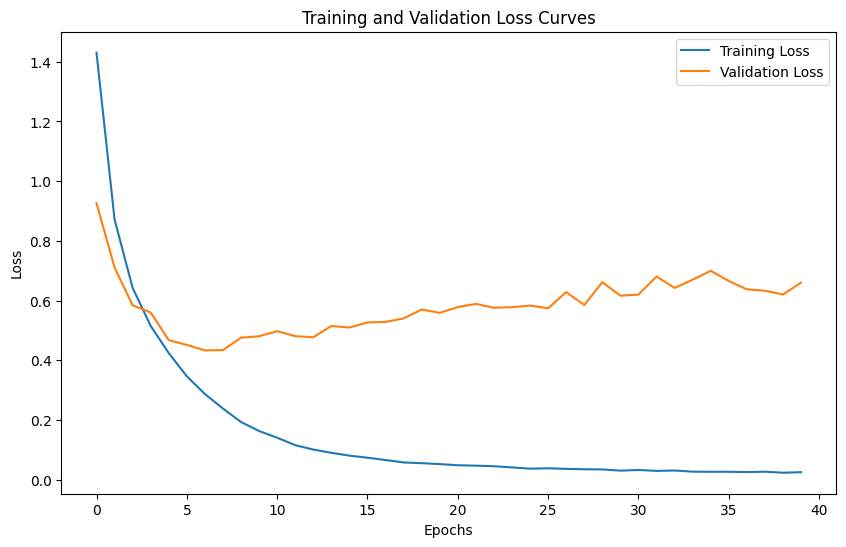

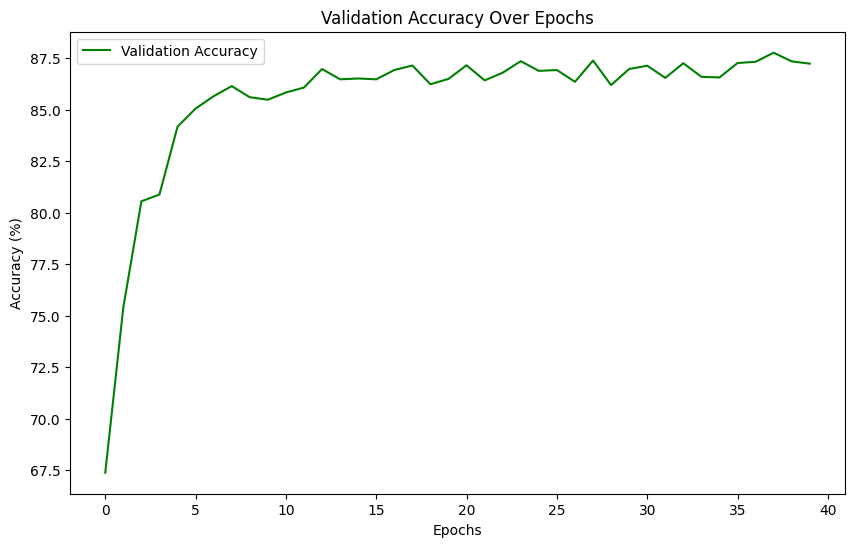

In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy', color='green')
plt.title('Validation Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


LOADING THE SAVED BEST RESNET-18 MODEL

In [ ]:
# loading resnet 18 model
model.load_state_dict(torch.load(best_model_path))

model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

PRINTING THE WEIGHTS OF THE RESNET-18 MODEL

In [ ]:
print(model.layer3.state_dict().values())
#-2.7388e-02

odict_values([tensor([[[[-0.4823, -0.4798, -0.2041],
          [-0.2735, -0.1303,  0.0223],
          [-0.3069, -0.2024, -0.1503]],

         [[-0.1484, -0.2622,  0.1637],
          [-0.3437, -0.2482,  0.1010],
          [-0.2483, -0.1937,  0.1081]],

         [[ 0.2961,  0.2942,  0.0578],
          [ 0.2428, -0.0747, -0.0940],
          [ 0.0764, -0.1357, -0.1860]],

         ...,

         [[ 0.4018,  0.2145,  0.1732],
          [-0.2078, -0.0939, -0.0161],
          [-0.1878, -0.0440, -0.0661]],

         [[ 0.1635,  0.2444,  0.1551],
          [-0.3343, -0.3495, -0.4143],
          [-0.4296, -0.3238, -0.2242]],

         [[ 0.1399,  0.0330,  0.2919],
          [ 0.1652,  0.0403,  0.0174],
          [-0.2606, -0.4539,  0.0260]]],


        [[[ 0.3105, -0.2084, -0.4002],
          [ 0.2307, -0.2298, -0.6801],
          [-0.1298, -0.2868, -0.5023]],

         [[ 0.0609, -0.1818, -0.3280],
          [-0.0558, -0.1481, -0.3888],
          [-0.3056, -0.1148, -0.3099]],

         [[-0.439

DEFINING THE STRUCTURE OF TRANSFORMER LAYER

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, in_channels, dim_feedforward=2048, nhead=4, dropout=0.1, expansion=2):
        super(TransformerEncoderLayer, self).__init__()
        self.expansion = expansion  # Store as instance variable
        self.self_attn = nn.MultiheadAttention(embed_dim=in_channels, num_heads=nhead, dropout=dropout, batch_first=True)

        self.linear1 = nn.Linear(in_channels, dim_feedforward)
        self.linear2 = nn.Linear(dim_feedforward, in_channels * self.expansion)
        self.dropout = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(in_channels)
        self.norm2 = nn.LayerNorm(in_channels * self.expansion)
        self.activation = nn.ReLU()
        self.channel_upscale = nn.Conv2d(in_channels, in_channels * self.expansion, kernel_size=1)  # Use self.expansion


    def forward(self, src):
        batch_size, channels, height, width = src.size()

        # Reshape and permute src for attention
        src_flat = src.permute(0, 2, 3, 1).reshape(batch_size, height * width, channels)  # [batch, C, H, W] -> [batch, H*W, C]
        #print("shape of src flat",src_flat.shape)

        attn_output, _ = self.self_attn(src_flat, src_flat, src_flat)
        attn_output = attn_output.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape back to [batch, C, H, W]
        #print(attn_output.shape)
        #print(src.shape)

        src = src.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape from [batch, C, H, W] -> [batch, H, W, C]
        #print(src.shape)

        src = src + self.dropout(attn_output)
        #print(src.shape)
        src = self.norm1(src)

        # Flatten for feedforward layers
        src_view = src.view(batch_size, channels, -1).transpose(1, 2)  # [batch, H*W, C]
        ff_output = self.linear1(src_view)
        ff_output = self.activation(ff_output)
        ff_output = self.dropout(ff_output)
        ff_output = self.linear2(ff_output)
        ff_output = ff_output.transpose(1, 2).view(batch_size, channels * self.expansion, height, width)  # Ensure the reshape matches original H and W

        # Apply dropout before adding
        ff_output = self.dropout(ff_output)

        #print("ff output:",ff_output.shape)

        src = src.reshape(batch_size, channels, height, width).permute(0, 1, 3, 2)  # Reshape from [batch, H, W, C] -> [batch, C, H, W]

        # Ensure the upscaled output is used if expansion is applied
        if self.expansion != 1:
            src = self.channel_upscale(src)  # Upscale src to match the expanded ff_output

        #print("src original:",src.shape)

        batch_size, channels, height, width = src.size()

        src = src + ff_output

        src = src.reshape(batch_size, height, width, channels).permute(0, 1, 2, 3)  # Reshape to [batch, H, W, C]
        #print("src changed:",src.shape)

        src = self.norm2(src)

        src = src.reshape(batch_size, channels, height, width).permute(0, 1, 3, 2)  # Reshape to [batch, C, H, W]

        return src


m = TransformerEncoderLayer(256)
n = TransformerEncoderLayer(256)

print(m)

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
  )
  (linear1): Linear(in_features=256, out_features=2048, bias=True)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (activation): ReLU()
  (channel_upscale): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
)


STRUCTURE FOR HYBRID MODEL

In [ ]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        self.resnet = model
        self.resnet.layer4 = TransformerEncoderLayer(256)
        self.resnet.fc = nn.Linear(512, 10)

    def forward(self, x):
        return self.resnet(x)


model_hybrid = ModifiedResNet18()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hybrid.to(device)

ModifiedResNet18(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
   

TRANSFER THE WEIGHTS FROM RESNET-18 MODEL TO HYBRID MODEL

In [ ]:
# Transfer weights from the first three layers
for name, module in model.named_children():
    if name in ['conv1', 'bn1', 'relu', 'maxpool', 'layer1', 'layer2', 'layer3']:
        getattr(model_hybrid.resnet, name).load_state_dict(module.state_dict())
    else:
        break  # Stop after layer3, do not proceed to layer4 and beyond


In [ ]:
# Transfer weights from the fourth layers

getattr(model_hybrid.resnet, 'layer4').load_state_dict(n.state_dict())




<All keys matched successfully>

PRINTING THE WEIGHTS OF HYBRID MODEL

In [ ]:
print(n.state_dict().values())

odict_values([tensor([[-0.0370, -0.0029, -0.0180,  ...,  0.0370,  0.0040, -0.0342],
        [ 0.0487, -0.0759, -0.0573,  ...,  0.0353, -0.0346, -0.0227],
        [-0.0225, -0.0471,  0.0218,  ..., -0.0502,  0.0174,  0.0120],
        ...,
        [-0.0338,  0.0754, -0.0276,  ...,  0.0413,  0.0273, -0.0375],
        [-0.0531,  0.0185,  0.0527,  ...,  0.0543,  0.0595,  0.0215],
        [ 0.0714,  0.0379, -0.0328,  ..., -0.0085,  0.0140, -0.0751]]), tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.,

In [ ]:
print(model_hybrid.resnet.layer3.state_dict().values())

odict_values([tensor([[[[-0.4823, -0.4798, -0.2041],
          [-0.2735, -0.1303,  0.0223],
          [-0.3069, -0.2024, -0.1503]],

         [[-0.1484, -0.2622,  0.1637],
          [-0.3437, -0.2482,  0.1010],
          [-0.2483, -0.1937,  0.1081]],

         [[ 0.2961,  0.2942,  0.0578],
          [ 0.2428, -0.0747, -0.0940],
          [ 0.0764, -0.1357, -0.1860]],

         ...,

         [[ 0.4018,  0.2145,  0.1732],
          [-0.2078, -0.0939, -0.0161],
          [-0.1878, -0.0440, -0.0661]],

         [[ 0.1635,  0.2444,  0.1551],
          [-0.3343, -0.3495, -0.4143],
          [-0.4296, -0.3238, -0.2242]],

         [[ 0.1399,  0.0330,  0.2919],
          [ 0.1652,  0.0403,  0.0174],
          [-0.2606, -0.4539,  0.0260]]],


        [[[ 0.3105, -0.2084, -0.4002],
          [ 0.2307, -0.2298, -0.6801],
          [-0.1298, -0.2868, -0.5023]],

         [[ 0.0609, -0.1818, -0.3280],
          [-0.0558, -0.1481, -0.3888],
          [-0.3056, -0.1148, -0.3099]],

         [[-0.439

TRAINING THE HYBRID MODEL FOR FINETUNING

In [ ]:
# training for finetuning2 (different way of loading weight)

epochs = 50
best_val_loss = float('inf')
best_accuracy = 0
early_stopping_counter = 0
patience = 50

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model_hybrid.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_hybrid(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model_hybrid.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_hybrid(images)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(total_val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_accuracy = val_accuracy
        torch.save(model_hybrid.state_dict(), '/content/drive/My Drive/best_model_hybrid_finetune2.pth')
        print('New best model saved')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break


Epoch 1: Train Loss: 0.4516, Train Accuracy: 84.54%, Validation Loss: 0.4118, Validation Accuracy: 86.34%
New best model saved
Epoch 2: Train Loss: 0.3306, Train Accuracy: 88.74%, Validation Loss: 0.4238, Validation Accuracy: 85.94%
Epoch 3: Train Loss: 0.2704, Train Accuracy: 90.75%, Validation Loss: 0.4452, Validation Accuracy: 85.85%
Epoch 4: Train Loss: 0.2314, Train Accuracy: 91.93%, Validation Loss: 0.4204, Validation Accuracy: 86.88%
Epoch 5: Train Loss: 0.1970, Train Accuracy: 93.20%, Validation Loss: 0.3976, Validation Accuracy: 87.76%
New best model saved
Epoch 6: Train Loss: 0.1693, Train Accuracy: 94.07%, Validation Loss: 0.4510, Validation Accuracy: 86.74%
Epoch 7: Train Loss: 0.1482, Train Accuracy: 94.88%, Validation Loss: 0.4087, Validation Accuracy: 87.95%
Epoch 8: Train Loss: 0.1298, Train Accuracy: 95.59%, Validation Loss: 0.4612, Validation Accuracy: 86.99%
Epoch 9: Train Loss: 0.1156, Train Accuracy: 95.89%, Validation Loss: 0.4884, Validation Accuracy: 86.74%
Epoc

PLOTTING FOR TRAINING AND VALIDATION CURVE FOR HYBRID MODEL

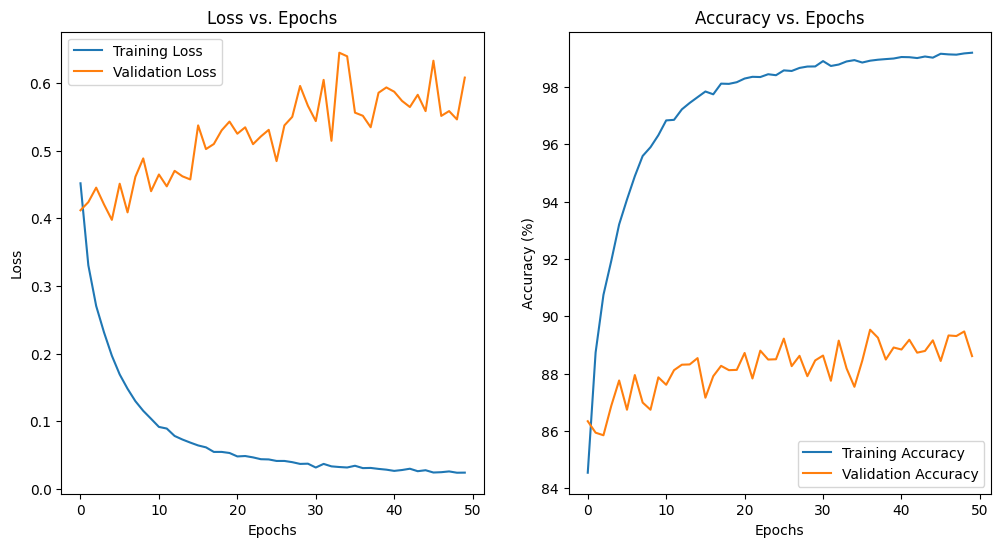

In [ ]:
# Plotting for finetuning 2
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


EXTRA CODING (ANOTHER WAY TO LOADING WEIGHTS TO TRAIN THE MODEL - FOR CHECKING)

In [ ]:
# training for finetuning 1

epochs = 50
best_val_loss = float('inf')
best_accuracy = 0
early_stopping_counter = 0
patience = 50

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model_hybrid.train()
    total_train_loss, correct_train, total_train = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model_hybrid(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_accuracy = 100 * correct_train / total_train
    train_losses.append(total_train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    model_hybrid.eval()
    total_val_loss, correct_val, total_val = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_hybrid(images)
            val_loss = criterion(outputs, labels)
            total_val_loss += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    val_accuracy = 100 * correct_val / total_val
    val_losses.append(total_val_loss / len(test_loader))
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch+1}: Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.2f}%, '
          f'Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        best_accuracy = val_accuracy
        torch.save(model_hybrid.state_dict(), '/content/drive/My Drive/best_model_hybrid_finetune.pth')
        print('New best model saved')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1
        if early_stopping_counter >= patience:
            print("Early stopping triggered.")
            break



Epoch 1: Train Loss: 0.6025, Train Accuracy: 79.35%, Validation Loss: 0.5323, Validation Accuracy: 81.82%
New best model saved
Epoch 2: Train Loss: 0.3903, Train Accuracy: 86.57%, Validation Loss: 0.4412, Validation Accuracy: 85.19%
New best model saved
Epoch 3: Train Loss: 0.3193, Train Accuracy: 88.95%, Validation Loss: 0.4198, Validation Accuracy: 86.19%
New best model saved
Epoch 4: Train Loss: 0.2654, Train Accuracy: 90.80%, Validation Loss: 0.3949, Validation Accuracy: 87.30%
New best model saved
Epoch 5: Train Loss: 0.2236, Train Accuracy: 92.20%, Validation Loss: 0.4016, Validation Accuracy: 87.45%
Epoch 6: Train Loss: 0.1975, Train Accuracy: 93.16%, Validation Loss: 0.3914, Validation Accuracy: 87.55%
New best model saved
Epoch 7: Train Loss: 0.1636, Train Accuracy: 94.25%, Validation Loss: 0.4386, Validation Accuracy: 86.90%
Epoch 8: Train Loss: 0.1425, Train Accuracy: 95.06%, Validation Loss: 0.4087, Validation Accuracy: 87.70%
Epoch 9: Train Loss: 0.1276, Train Accuracy: 95

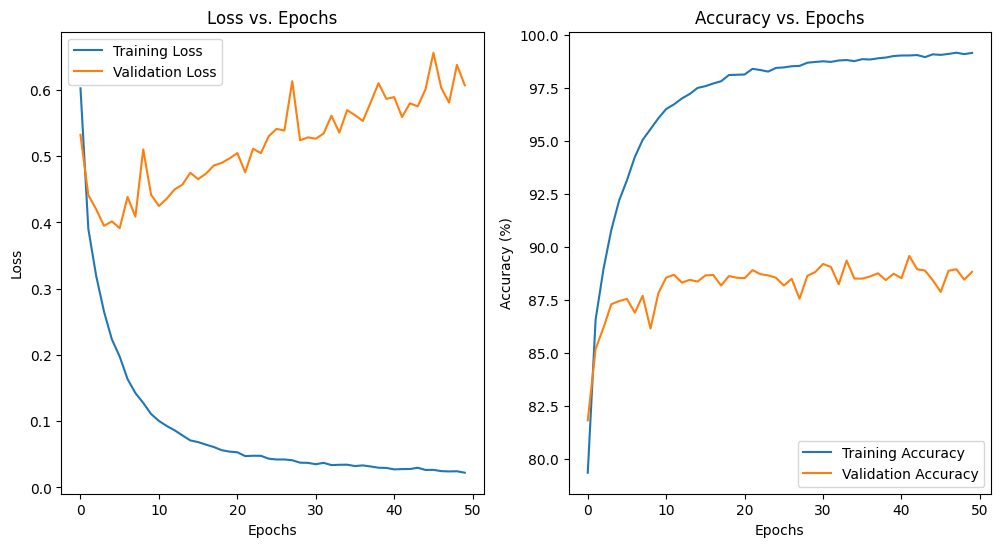

In [ ]:
# Plotting for finetuning 1
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()


FINDING NUMBER OF PARAMETERS IN RESNET-18 MODEL

In [ ]:
# finding the number of parameters in resnet 18

import torchvision.models as models

resnet18 = models.resnet18()
first_block_layer4 = resnet18.layer4[0]
second_block_layer4 = resnet18.layer4[1]
layer4 = resnet18.layer4

total_params_1 = sum(p.numel() for p in first_block_layer4.parameters() if p.requires_grad)
print(f"Total trainable parameters in the first block of layer4: {total_params_1}")

total_params_2 = sum(p.numel() for p in second_block_layer4.parameters() if p.requires_grad)
print(f"Total trainable parameters in the second block of layer4: {total_params_2}")

total_params = sum(p.numel() for p in layer4.parameters() if p.requires_grad)
print(f"Total trainable parameters of layer4: {total_params}")

total_params_resnet = sum(p.numel() for p in resnet18.parameters() if p.requires_grad)
print(f"Total trainable parameters of resnet18: {total_params_resnet}")

total  = total_params_1 + total_params_2
print(total)

Total trainable parameters in the first block of layer4: 3673088
Total trainable parameters in the second block of layer4: 4720640
Total trainable parameters of layer4: 8393728
Total trainable parameters of resnet18: 11689512
8393728


CHECKING AND VALIDATING LOSS FROM RESNET-18 MODEL

In [ ]:
# name and parameter of resent18 model

for name, param in model.named_parameters():
    print(f"{name}: {param.size()}")

In [ ]:
# validation loss for each class of cifar10

class_losses = {i: [] for i in range(10)}  # Assuming 10 classes for CIFAR-10
criterion = torch.nn.CrossEntropyLoss(reduction='none')  # Compute loss without reduction

# Evaluate losses per class
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        losses = criterion(outputs, labels)  # Individual losses

        for i in range(10):
            mask = (labels == i)
            class_specific_losses = losses[mask]
            if class_specific_losses.size(0) > 0:
                class_losses[i].extend(class_specific_losses.tolist())

# Calculate average loss per class
average_class_loss = {class_id: sum(losses)/len(losses) if losses else float('nan')
                      for class_id, losses in class_losses.items()}
print(average_class_loss)

# {0: 0.35496261298096965, 1: 0.3248053826979048, 2: 0.673665057818001, 3: 0.6067879536554114, 4: 0.451966260758325, 5: 0.6816568369081095, 6: 0.3913454906140103, 7: 0.4467033131048582, 8: 0.25055844731884036, 9: 0.15184973435864613}

In [ ]:
# validating loss
sum = 0
for i in range(10):
    sum = sum + average_class_loss[i]

print(sum/10)

# 0.43343010902150764